Paso 1: Crear el Modelo de Predicción
Cargar y Filtrar los Datos

<class 'pandas.core.frame.DataFrame'>
Index: 1637 entries, 0 to 1636
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                1637 non-null   int64  
 1   Trimester           1637 non-null   int64  
 2   District            1637 non-null   object 
 3   Neighbourhood       1637 non-null   object 
 4   Price (euro/month)  1637 non-null   float64
 5   Price (euro/m2)     1637 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 89.5+ KB
None
              Year    Trimester  Price (euro/month)  Price (euro/m2)
count  1637.000000  1637.000000         1637.000000      1637.000000
mean   2016.487477     2.499084          788.373366        11.742211
std       1.704480     1.117555          257.074112         2.490496
min    2014.000000     1.000000          142.340000         3.180000
25%    2015.000000     2.000000          621.430000        10.000000
50%    2016.000000     2.

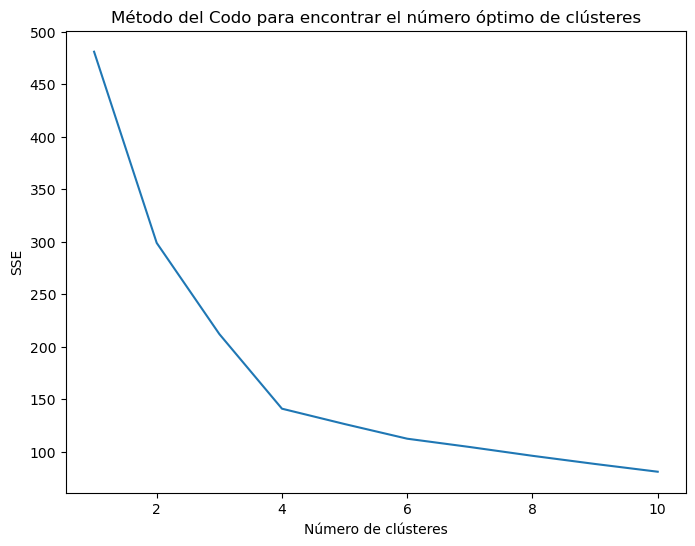

MAE: 0.5323420349781163, MSE: 0.7816710507899096, RMSE: 0.8841216266950547, R²: 0.8602473906857593


/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/3207832854.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Cluster'] = clusters
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/3207832854.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/3207832854.py:49: SettingWithCopyWarning:

Validación cruzada R²: -2.38020687473116e+17, 4.76041374946232e+17
      Year  Trimester      District  \
1637  2020          1  Ciutat Vella   
1638  2020          1  Ciutat Vella   
1639  2020          1  Ciutat Vella   
1640  2020          1  Ciutat Vella   
1641  2020          1      Eixample   
...    ...        ...           ...   
2306  2022          2    Sant Marti   
2307  2022          2    Sant Marti   
2308  2022          2    Sant Marti   
2309  2022          2    Sant Marti   
2310  2022          2    Sant Marti   

                                     Neighbourhood  Price (euro/m2)  
1637                                      el Raval        15.169933  
1638                                Gothic Quarter        15.638732  
1639                                la Barceloneta        19.962200  
1640         Sant Pere, Santa Caterina i la Ribera        16.988289  
1641                                    Fort Pienc        14.864318  
...                                         

/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/3207832854.py:114: RuntimeWarning: overflow encountered in expm1
  predictions_pandemic = np.expm1(predictions_pandemic_log)  # Deshacer la transformación logarítmica
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/3207832854.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_pandemic['Price (euro/m2)'] = predictions_pandemic


In [62]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')

# Filtrar los datos excluyendo los años 2020, 2021 y 2022
data_filtered = data[data['Year'] < 2020]

# Análisis Exploratorio de Datos (EDA)
print(data_filtered.info())
print(data_filtered.describe())

# Identificar y corregir outliers utilizando K-means clustering
numeric_data = data_filtered.select_dtypes(include=['float64', 'int64'])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(numeric_data)

# Calcular SSE para diferentes valores de k
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse[k] = kmeans.inertia_

# Graficar SSE vs. k para encontrar el número óptimo de clústeres
plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Número de clústeres")
plt.ylabel("SSE")
plt.title("Método del Codo para encontrar el número óptimo de clústeres")
plt.show()

# Aplicar K-means clustering con 4 clústeres (según el gráfico del codo)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
data_filtered['Cluster'] = clusters
data_filtered['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)
threshold = data_filtered['Distance_to_Centroid'].quantile(0.95)
data_filtered['Is_Outlier'] = data_filtered['Distance_to_Centroid'] > threshold

# Eliminar outliers
data_clean = data_filtered[~data_filtered['Is_Outlier']]

# Aplicar transformación logarítmica
data_clean['log_Price (euro/m2)'] = np.log1p(data_clean['Price (euro/m2)'])

# Codificación de variables categóricas
data_encoded = pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])

# División en características (X) y variable objetivo transformada (y)
X = data_encoded.drop(['Price (euro/m2)', 'log_Price (euro/m2)'], axis=1)
y = data_encoded['log_Price (euro/m2)']

# Escalado de los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar y evaluar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_log = linear_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Deshacer la transformación logarítmica
y_test_exp = np.expm1(y_test)

# Verificar y limpiar valores infinitos o extremadamente grandes
y_pred = np.where(np.isfinite(y_pred), y_pred, np.nan)
y_pred = np.where(y_pred < np.finfo(np.float64).max, y_pred, np.nan)

# Eliminar NaNs y valores infinitos para evitar errores
mask = ~np.isnan(y_pred) & ~np.isnan(y_test_exp)
y_pred = y_pred[mask]
y_test_exp = y_test_exp[mask]

# Calcular las métricas de error
mae = mean_absolute_error(y_test_exp, y_pred)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, y_pred)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}')

# Validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(linear_model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f'Validación cruzada R²: {scores.mean()}, {scores.std()}')

# Predecir valores para 2020-2022
years_pandemic = data[(data['Year'] == 2020) | (data['Year'] == 2021) | (data['Year'] == 2022)]

# Codificación de variables categóricas en los datos de la pandemia
years_pandemic_encoded = pd.get_dummies(years_pandemic, columns=['District', 'Neighbourhood'])
missing_cols = set(X.columns) - set(years_pandemic_encoded.columns)
for c in missing_cols:
    years_pandemic_encoded[c] = 0
years_pandemic_encoded = years_pandemic_encoded.loc[:, ~years_pandemic_encoded.columns.duplicated()]
years_pandemic_encoded = years_pandemic_encoded.reindex(columns=X.columns, fill_value=0)
years_pandemic_scaled = scaler.transform(years_pandemic_encoded)

# Realizar la predicción para los años de la pandemia
predictions_pandemic_log = linear_model.predict(years_pandemic_scaled)
predictions_pandemic = np.expm1(predictions_pandemic_log)  # Deshacer la transformación logarítmica
years_pandemic['Price (euro/m2)'] = predictions_pandemic

# Mostrar las predicciones para los años de la pandemia
print(years_pandemic[['Year', 'Trimester', 'District', 'Neighbourhood', 'Price (euro/m2)']])

# Guardar las predicciones en un archivo CSV
years_pandemic.to_csv('predictions_pandemic_2020_2022.csv', index=False)



Paso 2: Reconstruir el Dataset

In [46]:
# # Cargar el dataset original nuevamente para asegurarnos de que esté completo
# data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')

# # Filtrar los datos para excluir los años 2020, 2021 y 2022
# data_filtered = data[data['Year'] < 2020]

# # Filtrar las predicciones para los años 2020, 2021 y 2022
# predictions_pandemic = pd.read_csv('predictions_pandemic_2020_2022.csv')

# # Seleccionar las columnas relevantes de las predicciones
# predictions_pandemic = predictions_pandemic[['Year', 'Trimester', 'District', 'Neighbourhood', 'Price (euro/m2)']]

# # Unir los datos filtrados con las predicciones
# data_reconstructed = pd.concat([data_filtered, predictions_pandemic], ignore_index=True)

# # Guardar el dataset reconstruido en un archivo CSV
# data_reconstructed.to_csv('data_reconstruido_2014_2022.csv', index=False)

# print('El dataset reconstruido ha sido guardado como data_reconstruido_2014_2022.csv')


Paso 1: Análisis Exploratorio de Datos (EDA)

In [47]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Cargar el dataset reconstruido
# data_reconstructed = pd.read_csv('data_reconstruido_2014_2022.csv')

# # Visualizar información general del dataset
# print(data_reconstructed.info())
# print(data_reconstructed.head())
# print(data_reconstructed.tail())
# print(data_reconstructed.describe())

# # Visualizaciones iniciales
# sns.histplot(data_reconstructed['Price (euro/m2)'], kde=True)
# plt.title('Distribución de Price (euro/m2)')
# plt.show()

# sns.boxplot(x='Year', y='Price (euro/m2)', data=data_reconstructed)
# plt.title('Boxplot de Price (euro/m2) por Año')
# plt.show()

# sns.lineplot(x='Year', y='Price (euro/m2)', data=data_reconstructed)
# plt.title('Tendencia de Price (euro/m2) a lo largo de los años')
# plt.show()


Paso 2: Preprocesamiento de Datos

<class 'pandas.core.frame.DataFrame'>
Index: 1637 entries, 0 to 1636
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                1637 non-null   int64  
 1   Trimester           1637 non-null   int64  
 2   District            1637 non-null   object 
 3   Neighbourhood       1637 non-null   object 
 4   Price (euro/month)  1637 non-null   float64
 5   Price (euro/m2)     1637 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 89.5+ KB
None
              Year    Trimester  Price (euro/month)  Price (euro/m2)
count  1637.000000  1637.000000         1637.000000      1637.000000
mean   2016.487477     2.499084          788.373366        11.742211
std       1.704480     1.117555          257.074112         2.490496
min    2014.000000     1.000000          142.340000         3.180000
25%    2015.000000     2.000000          621.430000        10.000000
50%    2016.000000     2.

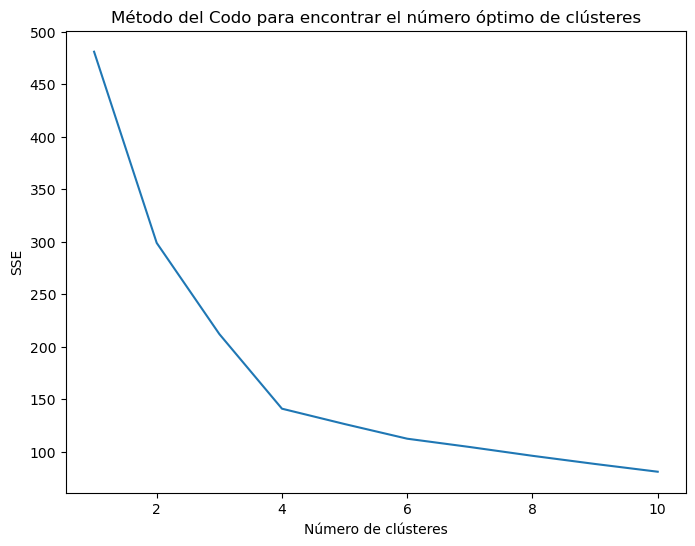

/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/1285970853.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Cluster'] = clusters
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/1285970853.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/1285970853.py:48: SettingWithCopyWarning:

Price (euro/m2) - MAE: 0.5322425414196181, MSE: 0.5376613978655185, RMSE: 0.733253979099683, R²: 0.9038731404939241
Price (euro/m2) - Validación cruzada R²: 0.8864328093979184, 0.012049985541082884
Price (euro/month) - MAE: 28.35903337103992, MSE: 1866.8910047570637, RMSE: 43.20753412030202, R²: 0.9561609195887526
Price (euro/month) - Validación cruzada R²: 0.9478567516703631, 0.008373072123960731
      Year  Trimester      District  \
1637  2020          1  Ciutat Vella   
1638  2020          1  Ciutat Vella   
1639  2020          1  Ciutat Vella   
1640  2020          1  Ciutat Vella   
1641  2020          1      Eixample   
...    ...        ...           ...   
2306  2022          2    Sant Marti   
2307  2022          2    Sant Marti   
2308  2022          2    Sant Marti   
2309  2022          2    Sant Marti   
2310  2022          2    Sant Marti   

                                     Neighbourhood  Predicted Price (euro/m2)  \
1637                                      el Rava

/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/1285970853.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_pandemic['Predicted Price (euro/m2)'] = predictions_pandemic_m2
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/1285970853.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_pandemic['Predicted Price (euro/month)'] = predictions_pandemic_month


In [48]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split, KFold, cross_val_score
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.cluster import KMeans
# from scipy import stats

# # Cargar los datos
# data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')

# # Filtrar los datos excluyendo los años 2020, 2021 y 2022
# data_filtered = data[data['Year'] < 2020]

# # Análisis Exploratorio de Datos (EDA)
# print(data_filtered.info())
# print(data_filtered.describe())

# # Identificar y corregir outliers utilizando K-means clustering
# numeric_data = data_filtered.select_dtypes(include=['float64', 'int64'])
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(numeric_data)

# # Calcular SSE para diferentes valores de k
# sse = {}
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(data_scaled)
#     sse[k] = kmeans.inertia_

# # Graficar SSE vs. k para encontrar el número óptimo de clústeres
# plt.figure(figsize=(8, 6))
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel("Número de clústeres")
# plt.ylabel("SSE")
# plt.title("Método del Codo para encontrar el número óptimo de clústeres")
# plt.show()

# # Aplicar K-means clustering con 4 clústeres (según el gráfico del codo)
# kmeans = KMeans(n_clusters=4, random_state=42)
# clusters = kmeans.fit_predict(data_scaled)
# data_filtered['Cluster'] = clusters
# data_filtered['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)
# threshold = data_filtered['Distance_to_Centroid'].quantile(0.95)
# data_filtered['Is_Outlier'] = data_filtered['Distance_to_Centroid'] > threshold

# # Eliminar outliers
# data_clean = data_filtered[~data_filtered['Is_Outlier']]

# # Aplicar transformación logarítmica
# data_clean['log_Price (euro/m2)'] = np.log1p(data_clean['Price (euro/m2)'])
# data_clean['log_Price (euro/month)'] = np.log1p(data_clean['Price (euro/month)'])

# # Codificación de variables categóricas
# data_encoded = pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])

# # División en características (X) y variable objetivo transformada (y)
# X = data_encoded.drop(['Price (euro/m2)', 'log_Price (euro/m2)', 'Price (euro/month)', 'log_Price (euro/month)'], axis=1)
# y_log_price_m2 = data_encoded['log_Price (euro/m2)']
# y_log_price_month = data_encoded['log_Price (euro/month)']

# # Escalado de los datos
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # División en conjuntos de entrenamiento y prueba para Price (euro/m2)
# X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_scaled, y_log_price_m2, test_size=0.2, random_state=42)

# # Entrenar y evaluar el modelo Ridge para Price (euro/m2)
# ridge_model_m2 = Ridge(alpha=1.0)
# ridge_model_m2.fit(X_train_m2, y_train_m2)
# y_pred_log_m2 = ridge_model_m2.predict(X_test_m2)
# y_pred_m2 = np.expm1(y_pred_log_m2)  # Deshacer la transformación logarítmica
# y_test_exp_m2 = np.expm1(y_test_m2)

# mae_m2 = mean_absolute_error(y_test_exp_m2, y_pred_m2)
# mse_m2 = mean_squared_error(y_test_exp_m2, y_pred_m2)
# rmse_m2 = np.sqrt(mse_m2)
# r2_m2 = r2_score(y_test_exp_m2, y_pred_m2)

# print(f'Price (euro/m2) - MAE: {mae_m2}, MSE: {mse_m2}, RMSE: {rmse_m2}, R²: {r2_m2}')

# # Validación cruzada con KFold para Price (euro/m2)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores_m2 = cross_val_score(ridge_model_m2, X_train_m2, y_train_m2, cv=kf, scoring='r2', n_jobs=-1)
# print(f'Price (euro/m2) - Validación cruzada R²: {scores_m2.mean()}, {scores_m2.std()}')

# # División en conjuntos de entrenamiento y prueba para Price (euro/month)
# X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(X_scaled, y_log_price_month, test_size=0.2, random_state=42)

# # Entrenar y evaluar el modelo Ridge para Price (euro/month)
# ridge_model_month = Ridge(alpha=1.0)
# ridge_model_month.fit(X_train_month, y_train_month)
# y_pred_log_month = ridge_model_month.predict(X_test_month)
# y_pred_month = np.expm1(y_pred_log_month)  # Deshacer la transformación logarítmica
# y_test_exp_month = np.expm1(y_test_month)

# mae_month = mean_absolute_error(y_test_exp_month, y_pred_month)
# mse_month = mean_squared_error(y_test_exp_month, y_pred_month)
# rmse_month = np.sqrt(mse_month)
# r2_month = r2_score(y_test_exp_month, y_pred_month)

# print(f'Price (euro/month) - MAE: {mae_month}, MSE: {mse_month}, RMSE: {rmse_month}, R²: {r2_month}')

# # Validación cruzada con KFold para Price (euro/month)
# scores_month = cross_val_score(ridge_model_month, X_train_month, y_train_month, cv=kf, scoring='r2', n_jobs=-1)
# print(f'Price (euro/month) - Validación cruzada R²: {scores_month.mean()}, {scores_month.std()}')

# # Predicción para los años de la pandemia (2020, 2021, 2022)
# years_pandemic = data[(data['Year'] == 2020) | (data['Year'] == 2021) | (data['Year'] == 2022)]
# years_pandemic_encoded = pd.get_dummies(years_pandemic, columns=['District', 'Neighbourhood'])
# missing_cols = set(X.columns) - set(years_pandemic_encoded.columns)
# for c in missing_cols:
#     years_pandemic_encoded[c] = 0
# years_pandemic_encoded = years_pandemic_encoded.loc[:, ~years_pandemic_encoded.columns.duplicated()]
# years_pandemic_encoded = years_pandemic_encoded.reindex(columns=X.columns, fill_value=0)
# years_pandemic_scaled = scaler.transform(years_pandemic_encoded)

# # Realizar la predicción para los años de la pandemia
# predictions_pandemic_log_m2 = ridge_model_m2.predict(years_pandemic_scaled)
# predictions_pandemic_m2 = np.expm1(predictions_pandemic_log_m2)  # Deshacer la transformación logarítmica
# years_pandemic['Predicted Price (euro/m2)'] = predictions_pandemic_m2

# predictions_pandemic_log_month = ridge_model_month.predict(years_pandemic_scaled)
# predictions_pandemic_month = np.expm1(predictions_pandemic_log_month)  # Deshacer la transformación logarítmica
# years_pandemic['Predicted Price (euro/month)'] = predictions_pandemic_month

# # Mostrar las predicciones para los años de la pandemia
# print(years_pandemic[['Year', 'Trimester', 'District', 'Neighbourhood', 'Predicted Price (euro/m2)', 'Predicted Price (euro/month)']])

# # Guardar las predicciones en un archivo CSV
# years_pandemic.to_csv('predictions_pandemic_2020_2022.csv', index=False)



In [59]:
years_pandemic.describe()

,Year,Trimester,Price (euro/month),Price (euro/m2),Predicted Price (euro/m2),Predicted Price (euro/month)
count,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000
mean,2020.801187,2.298220,899.490950,13.087389,14.836743,1012.373570
std,0.748807,1.101841,233.602418,1.931372,2.216754,256.572562
min,2020.000000,1.000000,447.500000,3.900000,8.406286,518.153176
25%,2020.000000,1.000000,754.100000,11.800000,13.309564,842.853650
50%,2021.000000,2.000000,842.500000,13.000000,14.873438,958.655261
75%,2021.000000,3.000000,981.475000,14.200000,16.217470,1120.810019
max,2022.000000,4.000000,1944.500000,21.300000,21.909953,1889.199878


### RECONSTRUCCION DATASET 

In [49]:
# Cargar el dataset original nuevamente para asegurarnos de que esté completo
data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')

# Filtrar los datos para excluir los años 2020, 2021 y 2022
data_filtered = data[data['Year'] < 2020]

# Filtrar las predicciones para los años 2020, 2021 y 2022
predictions_pandemic = pd.read_csv('predictions_pandemic_2020_2022.csv')
#predictions_pandemic.info()
print(predictions_pandemic.describe())

# Seleccionar las columnas relevantes de las predicciones
predictions_pandemic = predictions_pandemic[['Year', 'Trimester', 'District', 'Neighbourhood', 'Price (euro/m2)', 'Price (euro/month)']]

# Unir los datos filtrados con las predicciones
data_reconstructed = pd.concat([data_filtered, predictions_pandemic], ignore_index=True)

# Guardar el dataset reconstruido en un archivo CSV
data_reconstructed.to_csv('data_reconstruido_2014_2022.csv', index=False)

print('El dataset reconstruido ha sido guardado como data_reconstruido_2014_2022.csv')


              Year   Trimester  Price (euro/month)  Price (euro/m2)  \
count   674.000000  674.000000          674.000000       674.000000   
mean   2020.801187    2.298220          899.490950        13.087389   
std       0.748807    1.101841          233.602418         1.931372   
min    2020.000000    1.000000          447.500000         3.900000   
25%    2020.000000    1.000000          754.100000        11.800000   
50%    2021.000000    2.000000          842.500000        13.000000   
75%    2021.000000    3.000000          981.475000        14.200000   
max    2022.000000    4.000000         1944.500000        21.300000   

       Predicted Price (euro/m2)  Predicted Price (euro/month)  
count                 674.000000                    674.000000  
mean                   14.836743                   1012.373570  
std                     2.216754                    256.572562  
min                     8.406286                    518.153176  
25%                    13.309564   

Paso 1: Análisis Exploratorio de Datos (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                2311 non-null   int64  
 1   Trimester           2311 non-null   int64  
 2   District            2311 non-null   object 
 3   Neighbourhood       2311 non-null   object 
 4   Price (euro/month)  2311 non-null   float64
 5   Price (euro/m2)     2311 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 108.5+ KB
None
              Year    Trimester  Price (euro/month)  Price (euro/m2)
count  2311.000000  2311.000000         2311.000000      2311.000000
mean   2017.745565     2.440502          820.780658        12.134531
std       2.463095     1.116498          255.450568         2.419414
min    2014.000000     1.000000          142.340000         3.180000
25%    2016.000000     1.000000          653.860000        10.500000
50%    2018.000000 

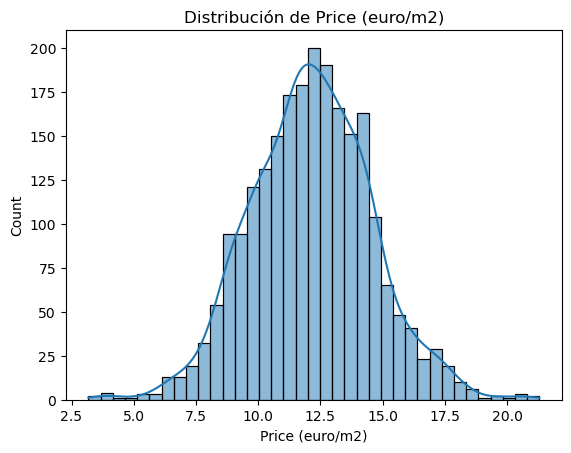

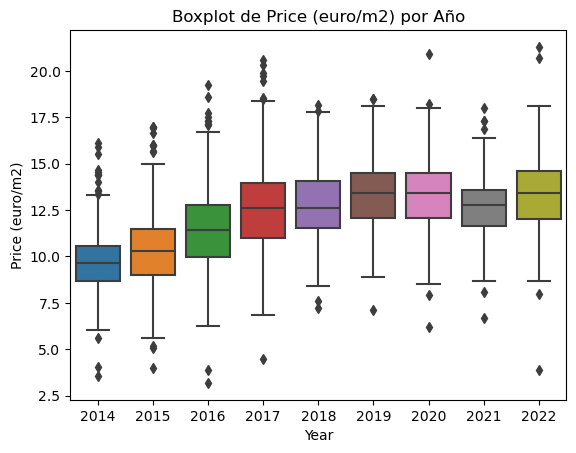

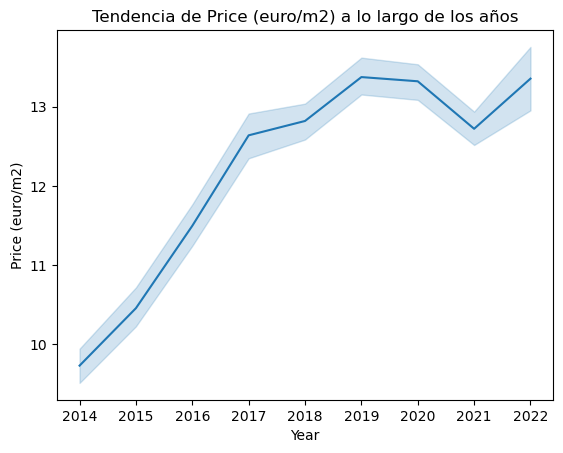

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset reconstruido
data_reconstructed = pd.read_csv('data_reconstruido_2014_2022.csv')

# Visualizar información general del dataset
print(data_reconstructed.info())
print(data_reconstructed.describe())

# Visualizaciones iniciales
sns.histplot(data_reconstructed['Price (euro/m2)'], kde=True)
plt.title('Distribución de Price (euro/m2)')
plt.show()

sns.boxplot(x='Year', y='Price (euro/m2)', data=data_reconstructed)
plt.title('Boxplot de Price (euro/m2) por Año')
plt.show()

sns.lineplot(x='Year', y='Price (euro/m2)', data=data_reconstructed)
plt.title('Tendencia de Price (euro/m2) a lo largo de los años')
plt.show()


Paso 2: Preprocesamiento de Datos

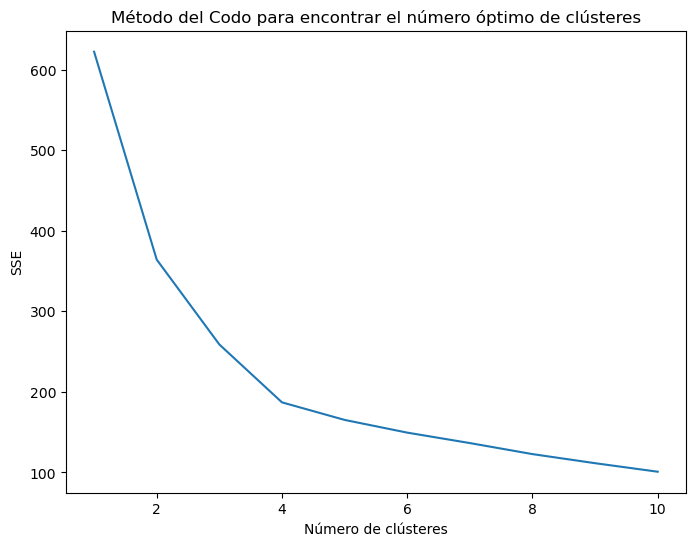

/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_94038/2239814955.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['log_Price (euro/m2)'] = np.log1p(data_clean['Price (euro/m2)'])


In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

# Identificar y corregir outliers utilizando K-means clustering
numeric_data = data_reconstructed.select_dtypes(include=['float64', 'int64'])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(numeric_data)

# Calcular SSE para diferentes valores de k
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse[k] = kmeans.inertia_

# Graficar SSE vs. k para encontrar el número óptimo de clústeres
plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Número de clústeres")
plt.ylabel("SSE")
plt.title("Método del Codo para encontrar el número óptimo de clústeres")
plt.show()

# Aplicar K-means clustering con 4 clústeres (según el gráfico del codo)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
data_reconstructed['Cluster'] = clusters
data_reconstructed['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)
threshold = data_reconstructed['Distance_to_Centroid'].quantile(0.95)
data_reconstructed['Is_Outlier'] = data_reconstructed['Distance_to_Centroid'] > threshold

# Eliminar outliers
data_clean = data_reconstructed[~data_reconstructed['Is_Outlier']]

# Aplicar transformación logarítmica
data_clean['log_Price (euro/m2)'] = np.log1p(data_clean['Price (euro/m2)'])

# Codificación de variables categóricas
data_encoded = pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])


Paso 3: Modelado con Ridge Regression

In [52]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# División en características (X) y variable objetivo transformada (y)
X = data_encoded.drop(['Price (euro/m2)', 'log_Price (euro/m2)'], axis=1)
y_log_price_m2 = data_encoded['log_Price (euro/m2)']

# Escalado de los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# División en conjuntos de entrenamiento y prueba para Price (euro/m2)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log_price_m2, test_size=0.2, random_state=42)

# Entrenar y evaluar el modelo Ridge para Price (euro/m2)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_log = ridge_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Deshacer la transformación logarítmica
y_test_exp = np.expm1(y_test)

mae = mean_absolute_error(y_test_exp, y_pred)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, y_pred)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}')

# Validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f'Validación cruzada R²: {scores.mean()}, {scores.std()}')


MAE: 0.5619945394799463, MSE: 0.5896703368232513, RMSE: 0.767899952352682, R²: 0.8870385221752718
Validación cruzada R²: 0.8930844187371003, 0.01470907262881394


In [53]:
# Crear un dataframe con los nuevos años
new_data = pd.DataFrame({
    'Year': [2024, 2024, 2024, 2024],
    'Trimester': [1, 2, 3, 4],
    'District': ['Eixample', 'Sant Martí', 'Gràcia', 'Ciutat Vella'],
    'Neighbourhood': ['Dreta de l\'Eixample', 'El Poblenou', 'Vila de Gràcia', 'El Raval']})

# Asegurarnos de que las columnas categóricas se procesen de la misma manera
new_data_encoded = pd.get_dummies(new_data, columns=['District', 'Neighbourhood'])

# Asegurarnos de que todas las columnas de características estén presentes
missing_cols = set(X.columns) - set(new_data_encoded.columns)
for c in missing_cols:
    new_data_encoded[c] = 0
new_data_encoded = new_data_encoded.loc[:, ~new_data_encoded.columns.duplicated()]
new_data_encoded = new_data_encoded.reindex(columns=X.columns, fill_value=0)

# Escalar las nuevas características usando el mismo escalador que se usó para el entrenamiento
new_data_scaled = scaler.transform(new_data_encoded)
# Realizar la predicción para los nuevos años
new_predictions_log = ridge_model.predict(new_data_scaled)
new_predictions = np.expm1(new_predictions_log)  # Deshacer la transformación logarítmica
new_data['Predicted Price (euro/m2)'] = new_predictions

# Mostrar las predicciones para los nuevos años
print(new_data[['Year', 'Trimester', 'District', 'Neighbourhood', 'Predicted Price (euro/m2)']])

# Guardar las predicciones en un archivo CSV
#new_data.to_csv('predictions_2023_2025.csv', index=False)

print('Las predicciones para los años 2023-2025 han sido guardadas en predictions_2023_2025.csv')



   Year  Trimester      District        Neighbourhood  \
0  2024          1      Eixample  Dreta de l'Eixample   
1  2024          2    Sant Martí          El Poblenou   
2  2024          3        Gràcia       Vila de Gràcia   
3  2024          4  Ciutat Vella             El Raval   

   Predicted Price (euro/m2)  
0                   7.972775  
1                   8.134410  
2                   8.183455  
3                   9.380040  
Las predicciones para los años 2023-2025 han sido guardadas en predictions_2023_2025.csv


In [54]:
###prueba prediccion

# Obtener los valores únicos de District y Neighbourhood
districts = data_reconstructed['District'].unique()
neighbourhoods = data_reconstructed['Neighbourhood'].unique()

# Crear un dataframe con el año 2023
new_year = [2023]
new_trimesters = [1, 2, 3, 4]
new_data_2023 = pd.DataFrame([(year, trimester, district, neighbourhood)
                              for year in new_year
                              for trimester in new_trimesters
                              for district in districts
                              for neighbourhood in neighbourhoods],
                             columns=['Year', 'Trimester', 'District', 'Neighbourhood'])

# Codificación de variables categóricas en los nuevos datos
new_data_encoded = pd.get_dummies(new_data_2023, columns=['District', 'Neighbourhood'])

# Asegurarnos de que todas las columnas de características estén presentes
missing_cols = set(data_encoded.columns) - set(new_data_encoded.columns)
for c in missing_cols:
    new_data_encoded[c] = 0
new_data_encoded = new_data_encoded.loc[:, ~new_data_encoded.columns.duplicated()]
new_data_encoded = new_data_encoded.reindex(columns=data_encoded.columns.drop(['Price (euro/m2)', 'log_Price (euro/m2)']), fill_value=0)

# Escalar las nuevas características usando el mismo escalador que se usó para el entrenamiento
new_data_scaled = scaler.transform(new_data_encoded)




In [55]:

# Realizar la predicción para el año 2023
new_predictions_log = ridge_model.predict(new_data_scaled)
new_predictions = np.expm1(new_predictions_log)  # Deshacer la transformación logarítmica
new_data_2023['Price (euro/m2)'] = new_predictions

# Guardar las predicciones en un archivo CSV
new_data_2023.to_csv('./predictions_2023.csv', index=False)


print('Las predicciones para el año 2023 han sido guardadas en predictions_2023.csv')
new_data_2023.describe()



Las predicciones para el año 2023 han sido guardadas en predictions_2023.csv


,Year,Trimester,Price (euro/m2)
count,3000.0,3000.00000,3000.000000
mean,2023.0,2.50000,8.038596
std,0.0,1.11822,0.812810
min,2023.0,1.00000,5.915268
25%,2023.0,1.75000,7.550196
50%,2023.0,2.50000,8.043719
75%,2023.0,3.25000,8.480715
max,2023.0,4.00000,11.629772


In [56]:
# Añadir las predicciones del 2023 al dataframe reconstruido
data_combined = pd.concat([data_reconstructed, new_data_2023], ignore_index=True)

# Guardar el dataset combinado en un archivo CSV
data_combined.to_csv('./data_reconstruido_2014_2023.csv', index=False)

print('El dataset combinado ha sido guardado como data_reconstruido_2014_2023.csv')



El dataset combinado ha sido guardado como data_reconstruido_2014_2023.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5311 entries, 0 to 5310
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  5311 non-null   int64  
 1   Trimester             5311 non-null   int64  
 2   District              5311 non-null   object 
 3   Neighbourhood         5311 non-null   object 
 4   Price (euro/month)    2311 non-null   float64
 5   Price (euro/m2)       5311 non-null   float64
 6   Cluster               2311 non-null   float64
 7   Distance_to_Centroid  2311 non-null   float64
 8   Is_Outlier            2311 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 373.6+ KB
None
              Year    Trimester  Price (euro/month)  Price (euro/m2)  \
count  5311.000000  5311.000000         2311.000000      5311.000000   
mean   2020.713613     2.474110          820.780658         9.820879   
std       3.070282     1.117755          255.450

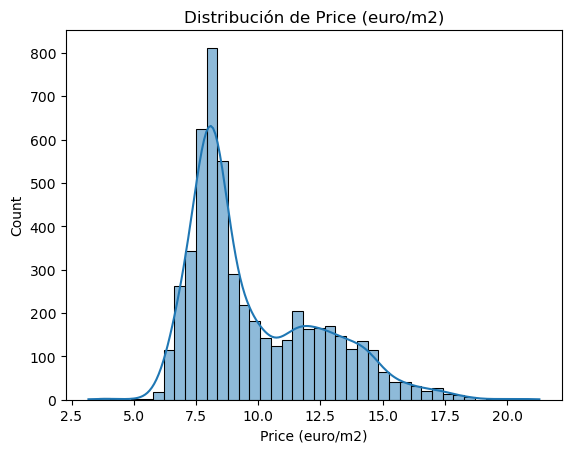

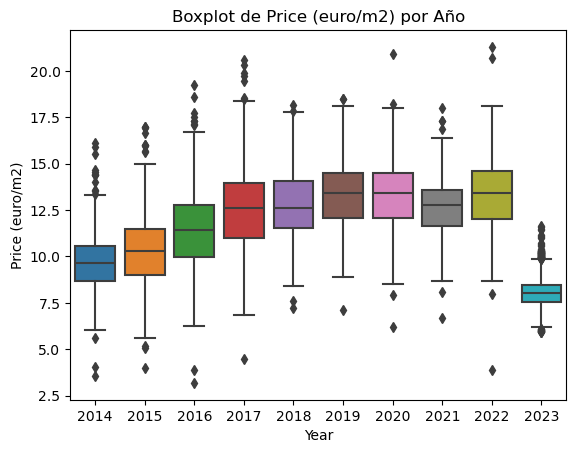

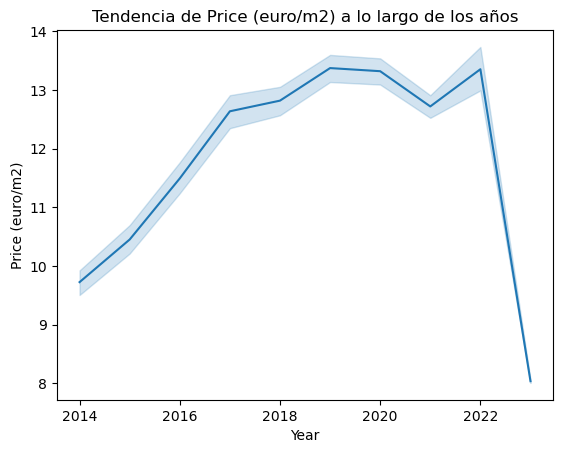

In [57]:
# Visualizar información general del dataset combinado
print(data_combined.info())
print(data_combined.describe())

# Visualizaciones
sns.histplot(data_combined['Price (euro/m2)'], kde=True)
plt.title('Distribución de Price (euro/m2)')
plt.show()

sns.boxplot(x='Year', y='Price (euro/m2)', data=data_combined)
plt.title('Boxplot de Price (euro/m2) por Año')
plt.show()

sns.lineplot(x='Year', y='Price (euro/m2)', data=data_combined)
plt.title('Tendencia de Price (euro/m2) a lo largo de los años')
plt.show()


